# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy
from sklearn.model_selection import GridSearchCV

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Functions

In [4]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    model = SVC()
    
    param_grid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search
  
def sentiment_score(review, tokenizer, model):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits)) +1

def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(accuracy_score)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))


# EDA Analysis

In [5]:
filename = "/Users/test/Downloads/Tweets.csv"

In [6]:
df_ = pd.read_csv(filename, nrows= 1000)
df_

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,569970938525016065,negative,1.0000,Late Flight,0.7065,United,NaN,tbird12lv,NaN,0,@united by the time I finally get to Dallas I ...,NaN,2015-02-23 13:23:55 -0800,Colorado,Mountain Time (US & Canada)
996,569970599377788928,negative,1.0000,Late Flight,1.0000,United,NaN,cristobalwong,NaN,0,@united I'm trying to get to my final destinat...,NaN,2015-02-23 13:22:35 -0800,San Francisco Bay Area,NaN
997,569970225443172353,negative,1.0000,Customer Service Issue,0.6667,United,NaN,itsmetsforme,NaN,0,@united that guy really has no customer servic...,NaN,2015-02-23 13:21:05 -0800,mets hell,NaN
998,569969999961391105,positive,0.6915,NaN,NaN,United,NaN,swampynomo,NaN,0,@united he has no priority and Iove it,NaN,2015-02-23 13:20:12 -0800,NJ/NYC,Eastern Time (US & Canada)


In [7]:
df = df_[["text",'airline_sentiment']].copy()
df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
995,@united by the time I finally get to Dallas I ...,negative
996,@united I'm trying to get to my final destinat...,negative
997,@united that guy really has no customer servic...,negative
998,@united he has no priority and Iove it,positive


In [8]:
text_mapping = {"positive":1, 'neutral':0, "negative":2}

df['target'] = df['airline_sentiment'].map(text_mapping)

In [9]:
df

,text,airline_sentiment,target
0,@VirginAmerica What @dhepburn said.,neutral,0
1,@VirginAmerica plus you've added commercials t...,positive,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0
3,@VirginAmerica it's really aggressive to blast...,negative,2
4,@VirginAmerica and it's a really big bad thing...,negative,2
...,...,...,...
995,@united by the time I finally get to Dallas I ...,negative,2
996,@united I'm trying to get to my final destinat...,negative,2
997,@united that guy really has no customer servic...,negative,2
998,@united he has no priority and Iove it,positive,1


In [10]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [13]:
df["berta_model"] = df["text"].apply(lambda review: sentiment_score(review, tokenizer, model))

In [14]:
df

,text,airline_sentiment,target,berta_model
0,@VirginAmerica What @dhepburn said.,neutral,0,5
1,@VirginAmerica plus you've added commercials t...,positive,1,5
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0,1
3,@VirginAmerica it's really aggressive to blast...,negative,2,4
4,@VirginAmerica and it's a really big bad thing...,negative,2,1
...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,1,5
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,2,1
14637,@AmericanAir Please bring American Airlines to...,neutral,0,1
14638,"@AmericanAir you have my money, you change my ...",negative,2,1


<Axes: xlabel='berta_model'>

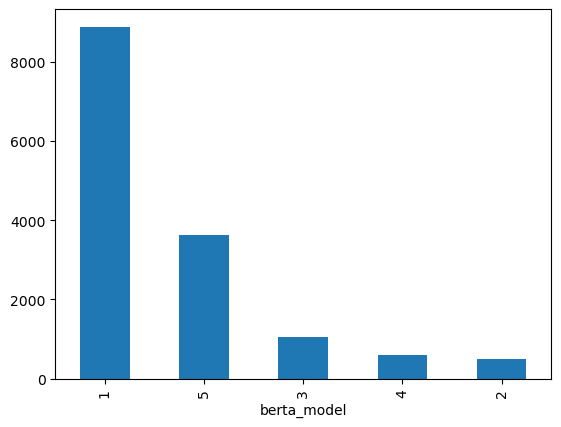

In [15]:
df["berta_model"].value_counts().plot.bar()

In [16]:
df["berta_model"].value_counts()

berta_model
1    8878
5    3621
3    1061
4     593
2     487
Name: count, dtype: int64

In [17]:
df["target"].value_counts()

target
2    9178
0    3099
1    2363
Name: count, dtype: int64

In [25]:
tfidf = TfidfVectorizer(max_features=2000)

In [26]:
# Applying TF-IDF to the specified column of the DataFrame
tfidf_matrix = tfidf.fit_transform(df['text'])

# Converting the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Concatenate the new DataFrame with the original DataFrame (optional)
# Make sure indexes align if not, reset index before concatenation.
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

In [27]:
df

,text,airline_sentiment,target,berta_model,00,000,10,100,10pm,11,...,yet,yo,york,you,young,your,yr,yup,yyz,zero
0,@VirginAmerica What @dhepburn said.,neutral,0,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,@VirginAmerica plus you've added commercials t...,positive,1,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.177307,0.0,0.000000,0.0,0.0,0.0,0.0
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,@VirginAmerica it's really aggressive to blast...,negative,2,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.220783,0.0,0.0,0.0,0.0
4,@VirginAmerica and it's a really big bad thing...,negative,2,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,1,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.191611,0.0,0.000000,0.0,0.0,0.0,0.0
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,2,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
14637,@AmericanAir Please bring American Airlines to...,neutral,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
14638,"@AmericanAir you have my money, you change my ...",negative,2,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.224023,0.0,0.151460,0.0,0.0,0.0,0.0


In [29]:
df.drop(["text", "airline_sentiment"], inplace=True, axis=1)

In [31]:
X,y = df.drop('target', axis=1), df['target']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [37]:
names = ["RFC", "DTC", "XGB", "LR", "SVC", "GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

NameError: name 'RepeatedStratifiedKFold' is not defined